# 1. Import libraries

In [1]:
import torchvision
import json 
import torch 
import skimage.io
import numpy as np
import tqdm
from PIL import Image, ImageDraw, ImageFont
import os
import torchvision
import cv2
from osgeo import gdal
import rasterio
from rasterio.windows import Window
from math import ceil
from shapely.geometry import Polygon, box
from shapely.validation import make_valid
import shapefile
import pandas as pd
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# 2. Chia anh tif thanh cac tile 512 overlap

In [27]:
''' Input '''
# Input TIF image
gridID = 'ID1275'
image_path = 'buildings_labels/ID127/ID1275_crop.tif'
# Input SHP shapefile
shapefile_path = 'buildings_labels/ID127/ID1275_5.shp'
# Output folder
output_dir = f'/mnt/data2tb/TungCT/ekGIS/tungct/tung_work/gee/satlas/dataset_buildings_fixed/raw_data_{gridID}'
# Output json
output_json = f'/mnt/data2tb/TungCT/ekGIS/tungct/tung_work/gee/satlas/dataset_buildings_fixed/raw_data_{gridID}/{gridID}_building_labels.json'

In [28]:
''' Cat anh tif '''
os.makedirs(output_dir, exist_ok=True)

tile_size = 512
step = tile_size // 2
old_row = 0
old_col = 0
with rasterio.open(image_path) as src:
    width = src.width
    height = src.height
    print(f"Original size: {width}x{height}")

    count = 0
    cut_width = width - (width%step)
    cut_height = height - (height%step)
    for top in range(0, cut_height, step):
        for left in range(0, cut_width, step):
            window_width = tile_size
            window_height = tile_size
            
            
            if top + tile_size > height:
                window_height = height - top
                top_adjusted = top - (512 - window_height)
                top = max(0, top_adjusted)
                window_height = tile_size
            
            if left + tile_size > width:
                window_width = width - left
                left_adjusted = left - (512 - window_width)
                left = max(0, left_adjusted)
                window_width = tile_size
                
            row = ceil(top / step)
            col = ceil(left / step)

            window = Window(left, top, tile_size, tile_size)
            print(f"[{top}, {left}]")

            transform = src.window_transform(window)
            tile = src.read(window=window)

            # Adjust the tile if it's smaller than 512x512
            if tile.shape[1] < tile_size or tile.shape[2] < tile_size:
                padded_tile = np.zeros((tile.shape[0], tile_size, tile_size), dtype=tile.dtype)
                padded_tile[:, :tile.shape[1], :tile.shape[2]] = tile
                tile = padded_tile

            output_path = os.path.join(output_dir, f"{gridID}_{row}_{col}.tif")

            with rasterio.open(
                output_path,
                "w",
                driver="GTiff",
                height=tile.shape[1],
                width=tile.shape[2],
                count=src.count,
                dtype=tile.dtype,
                crs=src.crs,
                transform=transform,
            ) as dest:
                dest.write(tile)

            print(f"Saved: {output_path}")

print(f"Total tiles: {count}")


Original size: 6520x9521
[0, 0]
Saved: /mnt/data2tb/TungCT/ekGIS/tungct/tung_work/gee/satlas/dataset_buildings_fixed/raw_data_ID1275/ID1275_0_0.tif
[0, 256]
Saved: /mnt/data2tb/TungCT/ekGIS/tungct/tung_work/gee/satlas/dataset_buildings_fixed/raw_data_ID1275/ID1275_0_1.tif
[0, 512]
Saved: /mnt/data2tb/TungCT/ekGIS/tungct/tung_work/gee/satlas/dataset_buildings_fixed/raw_data_ID1275/ID1275_0_2.tif
[0, 768]
Saved: /mnt/data2tb/TungCT/ekGIS/tungct/tung_work/gee/satlas/dataset_buildings_fixed/raw_data_ID1275/ID1275_0_3.tif
[0, 1024]
Saved: /mnt/data2tb/TungCT/ekGIS/tungct/tung_work/gee/satlas/dataset_buildings_fixed/raw_data_ID1275/ID1275_0_4.tif
[0, 1280]
Saved: /mnt/data2tb/TungCT/ekGIS/tungct/tung_work/gee/satlas/dataset_buildings_fixed/raw_data_ID1275/ID1275_0_5.tif
[0, 1536]
Saved: /mnt/data2tb/TungCT/ekGIS/tungct/tung_work/gee/satlas/dataset_buildings_fixed/raw_data_ID1275/ID1275_0_6.tif
[0, 1792]
Saved: /mnt/data2tb/TungCT/ekGIS/tungct/tung_work/gee/satlas/dataset_buildings_fixed/raw_

# 3. Xu ly nhan shp

## 3.1. Cac ham xu ly

In [29]:
''' Transform labels, save coords to shapefile '''
def small_image_transform_labels(width, height, labels, tile_size = 512):
    # width, height = image.size 
    tiles = []
    count = 0
    step = tile_size // 2
    print(width)
    print(height)
    cut_height = height - (height%step)
    cut_width = width - (width%step)
    for y_start in range(0, cut_height, step):
        for x_start in range(0, cut_width, step):
            x_end = min(x_start + tile_size, width)
            y_end = min(y_start + tile_size, height)
            
            if y_start + tile_size > height:
                y_adjusted = height - 512 
                y_start = max(0, y_adjusted)
                y_end = height

            
            if x_start + tile_size > width:
                x_adjusted = width - 512
                x_start = max(0, x_adjusted)
                x_end = width             
            # Create a bounding box for the tile 
            
            tile_box = box(x_start, y_start, x_end, y_end)
            
            
            
            # Find labels intersecting with the tile 
            tile_labels = []
            info = {}
            # info['count'] = count 
            info['row'] = ceil(y_start / step)
            info['column'] = ceil(x_start / step) 
            print(f"[{y_start}, {x_start}]")
            print(info)
            for polygon in labels:
                # Check if the polygon is valid, use buffer(0) to fix invalid geometries 
                if not polygon.is_valid: 
                    polygon = polygon.buffer(0)
                if polygon.is_valid:
                    intersected_polygon = polygon.intersection(tile_box)
                    if not intersected_polygon.is_empty:
                        # if they intersect
                        if intersected_polygon.geom_type == 'Polygon':
                            relative_polygon = Polygon([(p[0] - x_start, p[1] - y_start) for p in intersected_polygon.exterior.coords])
                            tile_labels.append(list(relative_polygon.exterior.coords))
                            
                        elif intersected_polygon.geom_type == 'MultiPolygon':
                            for sub_polygon in intersected_polygon.geoms:
                                relative_polygon = Polygon([(p[0] - x_start, p[1] - y_start) for p in sub_polygon.exterior.coords])
                                tile_labels.append(list(relative_polygon.exterior.coords))
                            
            tiles.append((info, tile_labels))
            count += 1
            
    
    return tiles

def read_shapefile(shp_path):
	"""
	Read a shapefile into a Pandas dataframe with a 'coords' column holding
	the geometry information. This uses the pyshp package
	"""

	#read file, parse out the records and shapes
	sf = shapefile.Reader(shp_path)
	fields = [x[0] for x in sf.fields][1:]
	records = sf.records()
	shps = [s.points for s in sf.shapes()]

	#write into a dataframe
	df = pd.DataFrame(columns=fields, data=records)
	df = df.assign(coords=shps)

	return df

def save_df_to_shapefile(df, output_path, epsg=3857):
    # Convert the 'coords' column to a 'geometry' column with shapely Polygons
    df['geometry'] = df['coords'].apply(lambda x: Polygon(x))
    gdf = gpd.GeoDataFrame(df, geometry='geometry')

    # Set the CRS
    gdf.set_crs(epsg=epsg, inplace=True)

    # Drop the 'coords' column as it is now represented by 'geometry'
    gdf.drop(columns=['coords'], inplace=True)

    # Save to shapefile
    gdf.to_file(output_path, driver='ESRI Shapefile')

    print(f"Shapefile saved as {output_path}")

# Convert coords to pixel coords
def convert_to_pixel(min_lon, max_lon, min_lat, max_lat, lon, lat, width, height):
    x = int((lon-min_lon)/(max_lon - min_lon) * width)
    y = int((max_lat - lat)/(max_lat - min_lat) * height)
    
    return x, y

## 3.2. Chuyen sang pixel coords

In [30]:
with rasterio.open(image_path) as file:
    big_image_data = file.read() # np arr
    big_meta_data = file.meta # dict

width = big_meta_data['width']
height = big_meta_data['height']

# longtitude : kinh do - x, latitude : vi do - y
min_lon = big_meta_data['transform'][2]
res_lon = big_meta_data['transform'][0]
max_lon = min_lon + width*res_lon 

max_lat = big_meta_data['transform'][5]
res_lat = big_meta_data['transform'][4]
min_lat = max_lat + height*res_lat


dataframe = read_shapefile(shapefile_path)
pixel_coords = []
for polygon in dataframe['coords']:
    polygon_geom = Polygon(polygon)
    valid_polygon = polygon_geom.buffer(0)
    if valid_polygon.is_valid:
        polygon_coord = []
        for point in polygon:
            lon = point[0]
            lat = point[1]
            x, y = convert_to_pixel(min_lon, max_lon, min_lat, max_lat, lon, lat, width, height)
            polygon_coord.append((x,y))
        pixel_coords.append(polygon_coord)
    else: 
        print("The polygon is invalid")
    
df = dataframe.copy()
df['pixel_coords'] = pixel_coords
polygons = df['pixel_coords'].tolist()
labels = [Polygon(coord) for coord in polygons]
tiles = small_image_transform_labels(width, height, labels)

6520
9521
[0, 0]
{'row': 0, 'column': 0}
[0, 256]
{'row': 0, 'column': 1}
[0, 512]
{'row': 0, 'column': 2}
[0, 768]
{'row': 0, 'column': 3}
[0, 1024]
{'row': 0, 'column': 4}
[0, 1280]
{'row': 0, 'column': 5}
[0, 1536]
{'row': 0, 'column': 6}
[0, 1792]
{'row': 0, 'column': 7}
[0, 2048]
{'row': 0, 'column': 8}
[0, 2304]
{'row': 0, 'column': 9}
[0, 2560]
{'row': 0, 'column': 10}
[0, 2816]
{'row': 0, 'column': 11}
[0, 3072]
{'row': 0, 'column': 12}
[0, 3328]
{'row': 0, 'column': 13}
[0, 3584]
{'row': 0, 'column': 14}
[0, 3840]
{'row': 0, 'column': 15}
[0, 4096]
{'row': 0, 'column': 16}
[0, 4352]
{'row': 0, 'column': 17}
[0, 4608]
{'row': 0, 'column': 18}
[0, 4864]
{'row': 0, 'column': 19}
[0, 5120]
{'row': 0, 'column': 20}
[0, 5376]
{'row': 0, 'column': 21}
[0, 5632]
{'row': 0, 'column': 22}
[0, 5888]
{'row': 0, 'column': 23}
[0, 6008]
{'row': 0, 'column': 24}
[256, 0]
{'row': 1, 'column': 0}
[256, 256]
{'row': 1, 'column': 1}
[256, 512]
{'row': 1, 'column': 2}
[256, 768]
{'row': 1, 'colum

## 3.3. Luu data

In [31]:
modified_tiles = []
for tile in tiles:
    polygon_coords = tile[1]
    converted_polygons_coords = [[[int(x), int(y)] for x, y in sublist] for sublist in polygon_coords]
    modified_tiles.append((tile[0], converted_polygons_coords))

In [32]:
with open(output_json, 'w') as f:
    json.dump(modified_tiles, f)

In [33]:
with open(output_json, 'r') as f:
    data = json.load(f)

In [34]:
data

[[{'row': 0, 'column': 0},
  [[[73, 497], [70, 497], [54, 503], [56, 512], [74, 512], [73, 497]],
   [[87, 479], [76, 485], [85, 512], [98, 512], [87, 479]],
   [[174, 461],
    [146, 470],
    [127, 481],
    [95, 492],
    [97, 498],
    [98, 499],
    [176, 474],
    [175, 462],
    [174, 461]],
   [[242, 475],
    [243, 470],
    [239, 459],
    [217, 465],
    [214, 476],
    [217, 480],
    [242, 475]]]],
 [{'row': 0, 'column': 1}, [[[511, 107], [512, 109], [512, 106], [511, 107]]]],
 [{'row': 0, 'column': 2},
  [[[470, 349], [488, 341], [450, 262], [404, 288], [439, 357], [470, 349]],
   [[504, 336],
    [504, 334],
    [479, 291],
    [461, 258],
    [456, 261],
    [453, 262],
    [466, 289],
    [478, 313],
    [491, 342],
    [504, 336]],
   [[338, 280], [501, 192], [464, 117], [461, 117], [301, 204], [338, 280]],
   [[453, 57],
    [455, 62],
    [458, 66],
    [489, 53],
    [493, 51],
    [487, 42],
    [453, 57]],
   [[433, 9], [453, 55], [487, 40], [487, 33], [478, 22],

# 4. Chia nhan -> gt.json

In [35]:
''' Directories '''
output_dir = 'dataset_buildings_fixed/dataset/polygon'
# output_dir = 'test/testt'
tif_image_dir = f'dataset_buildings_fixed/raw_data_{gridID}/'
# tif_image_dir = 'test'

In [36]:
with open(output_json, 'r') as file:
    data512 = json.load(file)

os.makedirs(output_dir, exist_ok=True)

for small_tile in data512:
    tile_label = []
    # row = small_tile[0]['row']
    # column = small_tile[0]['column']
    coords = small_tile[1]
    # Create file path for png image 
    count = small_tile[0]
    num_name = f"{count['row']}_{count['column']}"
    num_name_ = f"{gridID}_{count['row']}_{count['column']}"
    # tile_name = f"{gridID}_{count}"
    tile_path = os.path.join(output_dir, num_name_)
    png_image_path = f"{tile_path}/images/Image1/"
    os.makedirs(png_image_path, exist_ok=True)
    
    # Create file path for tif image
    tif_image_path = f'{tif_image_dir}{gridID}_{num_name}.tif'
    img = Image.open(tif_image_path)
    
    # Save tif image with png format
    img.save(f"{png_image_path}tci.png", format = 'png')
    
    for i, poly in enumerate(small_tile[1]):
        name = f"{num_name_}_{i}_building"
        # Long poly trong 1 list poly duy nhat la poly ngoai
        poly_coords = [poly]
        category = "building"
        prop = None 
        building_label = [name, poly_coords, category, prop]
        
        tile_label.append(building_label)
    
    with open(f"{tile_path}/gt.json", 'w') as file:
        json.dump(tile_label, file)

In [37]:
import os
import json
import shutil

# Đường dẫn đến folder tổng
main_folder_path = output_dir

# Duyệt qua từng folder con
for subfolder in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, subfolder)
    
    # Kiểm tra nếu đây là folder
    if os.path.isdir(subfolder_path):
        gt_json_path = os.path.join(subfolder_path, 'gt.json')
        
        # Kiểm tra nếu tệp gt.json tồn tại
        if os.path.exists(gt_json_path):
            with open(gt_json_path, 'r', encoding='utf-8') as file:
                try:
                    data = json.load(file)
                    
                    # Nếu giá trị là [], xóa folder con
                    if data == []:
                        shutil.rmtree(subfolder_path)
                        print(f"Đã xóa folder: {subfolder_path}")
                except json.JSONDecodeError:
                    print(f"Không thể đọc tệp JSON: {gt_json_path}")
        else:
            shutil.rmtree(subfolder_path)
            print(f"Đã xóa folder: {subfolder_path}")


Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_5_12
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_26_10
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_8_3
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_8_22
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_10_9
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_23_16
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_21_4
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_33_17
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_11_9
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_11_21
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_6_13
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_13_17
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_19_8
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID1275_20_24
Đã xóa folder: dataset_buildings_fixed/dataset/polygon/ID

In [38]:
import os
import shutil

# Đường dẫn đến folder tổng
main_folder_path = output_dir

# Duyệt qua từng folder con
for subfolder in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, subfolder)
    
    # Kiểm tra nếu đây là folder
    if os.path.isdir(subfolder_path):
        gt_json_path = os.path.join(subfolder_path, 'gt.json')
        
        # Nếu không có tệp gt.json, xóa folder con
        if not os.path.exists(gt_json_path):
            shutil.rmtree(subfolder_path)
            print(f"Đã xóa folder: {subfolder_path}")


In [ ]:
import os
import shutil

# Đường dẫn đến folder tổng
main_folder_path = r"path/to/your/main/folder"

# Duyệt qua từng folder con trong folder tổng
for subfolder in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, subfolder)
    
    # Kiểm tra nếu đây là một folder
    if os.path.isdir(subfolder_path):
        # Liệt kê các mục trong folder con
        items = os.listdir(subfolder_path)
        
        # Nếu folder con chỉ chứa 1 mục, xóa folder con
        if len(items) == 1:
            shutil.rmtree(subfolder_path)
            print(f"Đã xóa folder: {subfolder_path}")

In [39]:
import os
import json
import shutil
a=[]
# Đường dẫn đến folder tổng
main_folder_path = 'dataset_buildings_fixed/dataset/polygon'

# Duyệt qua từng folder con
for subfolder in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, subfolder)
    
    # Kiểm tra nếu đây là folder
    if os.path.isdir(subfolder_path):
        gt_json_path = os.path.join(subfolder_path, 'gt.json')
        
        # Kiểm tra nếu tệp gt.json tồn tại
        if os.path.exists(gt_json_path):
            with open(gt_json_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                a.append(len(data))

print(len(a))

1698


## Kiem tra nhan

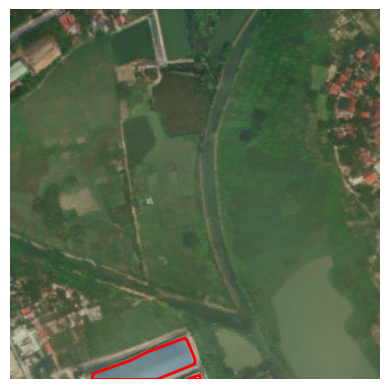

In [24]:
# Đường dẫn đến ảnh PNG và file JSON
image_path = 'dataset_buildings_fixed/dataset/polygon/ID127_39_45/images/Image1/tci.png'
json_path = 'dataset_buildings_fixed/dataset/polygon/ID127_39_45/gt.json'

# Đọc ảnh bằng PIL
image = Image.open(image_path)

# Đọc file JSON
with open(json_path, 'r') as f:
    data = json.load(f)

# Tạo một figure và axes
fig, ax = plt.subplots(1)
ax.imshow(image)

# Duyệt qua danh sách các polygon và vẽ lên ảnh
for item in data:
    # Cấu trúc JSON của bạn:
    # ["kcn_01_21_47_building", [[[x1, y1], [x2, y2], ...]], "building", null]
    polygon_name = item[0]  # Tên polygon
    coordinates = item[1][0]  # Tọa độ polygon
    object_type = item[2]  # Loại đối tượng (nếu cần dùng)

    # Chuyển tọa độ thành numpy array
    polygon = np.array(coordinates)

    # Vẽ polygon bằng matplotlib.patches.Polygon
    patch = patches.Polygon(
        polygon, closed=True, edgecolor='red', facecolor='none', linewidth=2
    )
    ax.add_patch(patch)

    # Hiển thị tên polygon (nếu cần)
    # centroid = np.mean(polygon, axis=0)
    # ax.text(centroid[0], centroid[1], polygon_name, color='red', fontsize=10)

# Hiển thị ảnh với các polygon
plt.axis('off')  # Tắt hiển thị trục
plt.show()

# 5. Cat anh tif cac ngay -> tci.png

In [87]:
def process_tif_folder(input_folder, output_folder, tile_size=512):
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".tif"):

            input_file_path = os.path.join(input_folder, file_name)
            
            day = file_name.split("_")[-1].replace(".tif", "")
            
            with rasterio.open(input_file_path) as src:
                width, height = src.width, src.height

                for i in range(0, height, tile_size):
                    for j in range(0, width, tile_size):
                        window = Window(j, i, tile_size, tile_size)
                        transform = src.window_transform(window)

                        tile = src.read(window=window)
                        
                        tile_height, tile_width = tile.shape[1], tile.shape[2]
                        if tile_height < tile_size or tile_width < tile_size:
                            # Nếu tile nhỏ hơn 512x512, bỏ qua
                            continue

                        tile_folder = os.path.join(output_folder, f"VN60111_{i // tile_size}_{j // tile_size}", "images", day)
                        os.makedirs(tile_folder, exist_ok=True)

                        # Lưu tile với tên "tci.png"
                        output_tile_path = os.path.join(tile_folder, "tci.png")
                        with rasterio.open(
                            output_tile_path,
                            "w",
                            driver="PNG",
                            height=tile.shape[1],
                            width=tile.shape[2],
                            count=tile.shape[0],
                            dtype=tile.dtype,
                            crs=src.crs,
                            transform=transform,
                        ) as dst:
                            dst.write(tile)
                            
                        if tile_height < tile_size or tile_width < tile_size:
                            os.remove(tile_folder)
                        
                        
                        # print(count)

input_folder = "tif_image_crop/testGG157"  
print(f"Input folder: {input_folder}")  
output_folder = "tif_image_crop/testGG157"  

# Thực hiện xử lý
process_tif_folder(input_folder, output_folder)


Input folder: tif_image_crop/testGG157


# 6. Chia train/test/val

In [10]:
def split_dataset(parent_dir, output_dir, train_ratio=0.8, test_ratio=0.1, val_ratio=0.1):
    # Get all subfolder names in the specified folder
    subfolders = [name for name in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, name))]
    
    # Shuffle the subfolder list
    random.shuffle(subfolders)
    
    # Calculate split indices
    total = len(subfolders)
    train_end = int(total * train_ratio)
    test_end = train_end + int(total * test_ratio)
    
    # Split into train, test, val
    train = subfolders[:train_end]
    test = subfolders[train_end:test_end]
    val = subfolders[test_end:]
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Write each split to its own JSON file
    train_json_path = os.path.join(output_dir, 'train.json')
    test_json_path = os.path.join(output_dir, 'test.json')
    val_json_path = os.path.join(output_dir, 'val.json')
    
    with open(train_json_path, 'w') as train_file:
        json.dump(train, train_file, indent=4)
    
    with open(test_json_path, 'w') as test_file:
        json.dump(test, test_file, indent=4)
    
    with open(val_json_path, 'w') as val_file:
        json.dump(val, val_file, indent=4)
    
    print(f"Dataset split completed.")
    # print(f"Train JSON saved to {train_json_path}")
    print(f"Test JSON saved to {test_json_path}")
    # print(f"Val JSON saved to {val_json_path}")

# Define the parent directory and output directory
parent_dir = 'dataset_buildings_fixed_small/dataset/polygon'
output_dir = 'dataset_buildings_fixed_small/splits/polygon'

# Split the dataset
split_dataset(parent_dir, output_dir)

Dataset split completed.
Test JSON saved to dataset_buildings_fixed_small/splits/polygon/test.json


# Bonus: Stack va cat anh tif

## RGB

In [13]:
# gop 8 anh tif
import glob
import os
import subprocess

# channels = ['B08', 'TCI', 'B05', 'B06', 'B07', 'B11', 'B12']
channels = ['B08']
path = 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8'
fnames = glob.glob(f'{path}/*.tif')
subprocess.call([
    'gdal_merge.py',
    '-o', 'dataset_x/results/stack_thaibinh_msb08.tif',
    # Keep bands separate in output file.
    '-separate',
] + fnames)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

## Multispectral


In [19]:
import glob
import os
import subprocess

channels = ['B08', 'TCI', 'B05', 'B06', 'B07', 'B11', 'B12']
fnames = []
for scene_name in os.listdir('dataset_x/sentinel2_data/VN10709'): # folder luu data
    image_fnames = glob.glob(os.path.join('dataset_x/sentinel2_data/VN10709/VN10709_*/VN10709_*/*.tif'.format(scene_name)))
    channel_to_fname = {fname.split('_')[-9].split('.')[0]: fname for fname in image_fnames}
    selected_fnames = [channel_to_fname[channel] for channel in channels]
    #selected_fnames = channel_to_fname['TCI']
    fnames.extend(selected_fnames)
    print(f"selected: {len(fnames)}")
# subprocess.call([
#     'gdal_merge.py',
#     '-o', 'dataset_x/results/stack_thaibinh_ms.tif',
#     # Keep bands separate in output file.
#     '-separate',
# ] + fnames)

selected: {'TCI': 'dataset_x/sentinel2_data/VN115_05_2024_11_2024_S2-20241218T042705Z-001/VN115_05_2024_11_2024_S2/VN115_05_2024_11_2024_S2_TCI_Image2.tif', 'B08': 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8/VN115_05_2024_12_2024_S2_B08_Image3.tif'}
selected: {'TCI': 'dataset_x/sentinel2_data/VN115_05_2024_11_2024_S2-20241218T042705Z-001/VN115_05_2024_11_2024_S2/VN115_05_2024_11_2024_S2_TCI_Image2.tif', 'B08': 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8/VN115_05_2024_12_2024_S2_B08_Image3.tif'}
selected: {'TCI': 'dataset_x/sentinel2_data/VN115_05_2024_11_2024_S2-20241218T042705Z-001/VN115_05_2024_11_2024_S2/VN115_05_2024_11_2024_S2_TCI_Image2.tif', 'B08': 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8/VN115_05_2024_12_2024_S2_B08_Image3.tif'}
selected: {'TCI': 'dataset_x/sentinel2_data/VN115_05_2024_11_2024_S2-2024

0

In [12]:
import glob
import os
import subprocess

channels = ['B08']
# path = 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8'
# fnames = glob.glob(f'{path}/*.tif')
# fnames
# subprocess.call([
#     'gdal_merge.py',
#     '-o', 'dataset_x/results/stack_thaibinh_b08.tif',
#     # Keep bands separate in output file.
#     '-separate',
# ] + fnames)
#channels = ['TCI']
# fnames = []
# dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8
for scene_name in os.listdir('dataset_x/sentinel2_data'): # folder luu data
    image_fnames = glob.glob(os.path.join('dataset_x/sentinel2_data/VN115_*/VN115_*/*.tif'.format(scene_name)))
    channel_to_fname = {file_name.split("_")[-2].replace(".tif", ""): file_name for file_name in image_fnames}
    # channel_to_fname = {fname.split('_')[-1].split('.')[0]: fname for fname in image_fnames}
    selected_fnames = [channel_to_fname[channel] for channel in channels]
    #selected_fnames = channel_to_fname['TCI']
    fnames.extend(selected_fnames)
    print(f"selected: {fnames}")
subprocess.call([
    'gdal_merge.py',
    '-o', 'dataset_x/results/stack_thaibinh_msb8.tif',
    # Keep bands separate in output file.
    '-separate',
] + fnames)

selected: ['dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8/VN115_05_2024_12_2024_S2_B08_Image6.tif', 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8/VN115_05_2024_12_2024_S2_B08_Image1.tif', 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8/VN115_05_2024_12_2024_S2_B08_Image2.tif', 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8/VN115_05_2024_12_2024_S2_B08_Image7.tif', 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8/VN115_05_2024_12_2024_S2_B08_Image8.tif', 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8/VN115_05_2024_12_2024_S2_B08_Image4.tif', 'dataset_x/sentinel2_data/VN115_05_2024_12_2024_S2_B8-20241223T023011Z-001/VN115_05_2024_12_2024_S2_B8/VN115_05_2024_12

0

## Cat anh tif stack -> tif chay inference

In [19]:
# cat anh tif stack luu lai vao kq
import rasterio
from rasterio.windows import Window
import os

input_folder = "dataset_x/sentinel2_data/VN60111/VN60111_B05_2024_05_01_2024_11_01_S2/xxx"
output_folder = "dataset_x/sentinel2_data/VN60111/VN60111_B05_2024_05_01_2024_11_01_S2/xxx"

os.makedirs(output_folder, exist_ok=True)

# test_folder = ["VN115_7_9", "VN115_2_5", "VN115_6_8", "VN115_6_2", "VN115_0_3"]

def process_tif_folder(input_folder, output_folder, tile_size=512):
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".tif"):

            input_file_path = os.path.join(input_folder, file_name)
            
            day = file_name.split("_")[-1].replace(".tif", "")
            
            with rasterio.open(input_file_path) as src:
                width, height = src.width, src.height

                for i in range(0, height, tile_size):
                    for j in range(0, width, tile_size):
                        window = Window(j, i, tile_size, tile_size)
                        transform = src.window_transform(window)

                        tile = src.read(window=window)
                        
                        tile_height, tile_width = tile.shape[1], tile.shape[2]
                        if tile_height < tile_size or tile_width < tile_size:
                            # Nếu tile nhỏ hơn 512x512, bỏ qua
                            continue

                        tile_folder = os.path.join(output_folder, f"VN60111_{i // tile_size}_{j // tile_size}", "images", day)
                        os.makedirs(tile_folder, exist_ok=True)

                        # Lưu tile với tên "tci.png"
                        output_tile_path = os.path.join(tile_folder, "infer.tif")
                        with rasterio.open(
                            output_tile_path,
                            "w",
                            driver="GTiff",
                            height=tile.shape[1],
                            width=tile.shape[2],
                            count=tile.shape[0],
                            dtype=tile.dtype,
                            crs=src.crs,
                            transform=transform,
                        ) as dst:
                            dst.write(tile)
                            
                        if tile_height < tile_size or tile_width < tile_size:
                            os.remove(tile_folder)
                        
                        
                        # print(count)
# Thực hiện xử lý
process_tif_folder(input_folder, output_folder)


In [ ]:
for task_idx, spec in enumerate(config['Tasks']):
    print()